<a href="https://colab.research.google.com/github/Divyansh00001/Human-activity-recognition-using-smartphones/blob/main/Human_Recognition_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
print(tf.version.VERSION)


2.13.0


In [13]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip


--2023-10-03 14:17:18--  https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip [following]
--2023-10-03 14:17:18--  https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip [following]
--2023-10-03 14:17:18--  https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connec

In [14]:
!unzip -n dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/LICENSE         
  inflating: dataset/README.md       
   creating: dataset/running/
  inflating: dataset/running/running_01_26Hz_4g_mg.csv  
  inflating: dataset/running/running_02_26Hz_4g_mg.csv  
  inflating: dataset/running/running_03_26Hz_4g_mg.csv  
  inflating: dataset/running/running_04_26Hz_4g_mg.csv  
  inflating: dataset/running/running_05_26Hz_4g_mg.csv  
  inflating: dataset/running/running_06_26Hz_4g_mg.csv  
  inflating: dataset/running/running_07_26Hz_4g_mg.csv  
  inflating: dataset/running/running_08_26Hz_4g_mg.csv  
  inflating: dataset/running/running_09_26Hz_4g_mg.csv  
  inflating: dataset/running/running_10_26Hz_4g_mg.csv  
  inflating: dataset/running/running_12_26Hz_4g_mg.csv  
  inflating: dataset/running/running_13_26Hz_4g_mg.csv  
  inflating: dataset/running/running_14_26Hz_4g_mg.csv  
  inflating: dataset/running/running_15_26Hz_4g_mg.csv  
  inflating: dataset/running/running_16_26Hz_4g_mg.c

In [15]:
import glob
import numpy as np

# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(92, 1000, 3)
(92,)


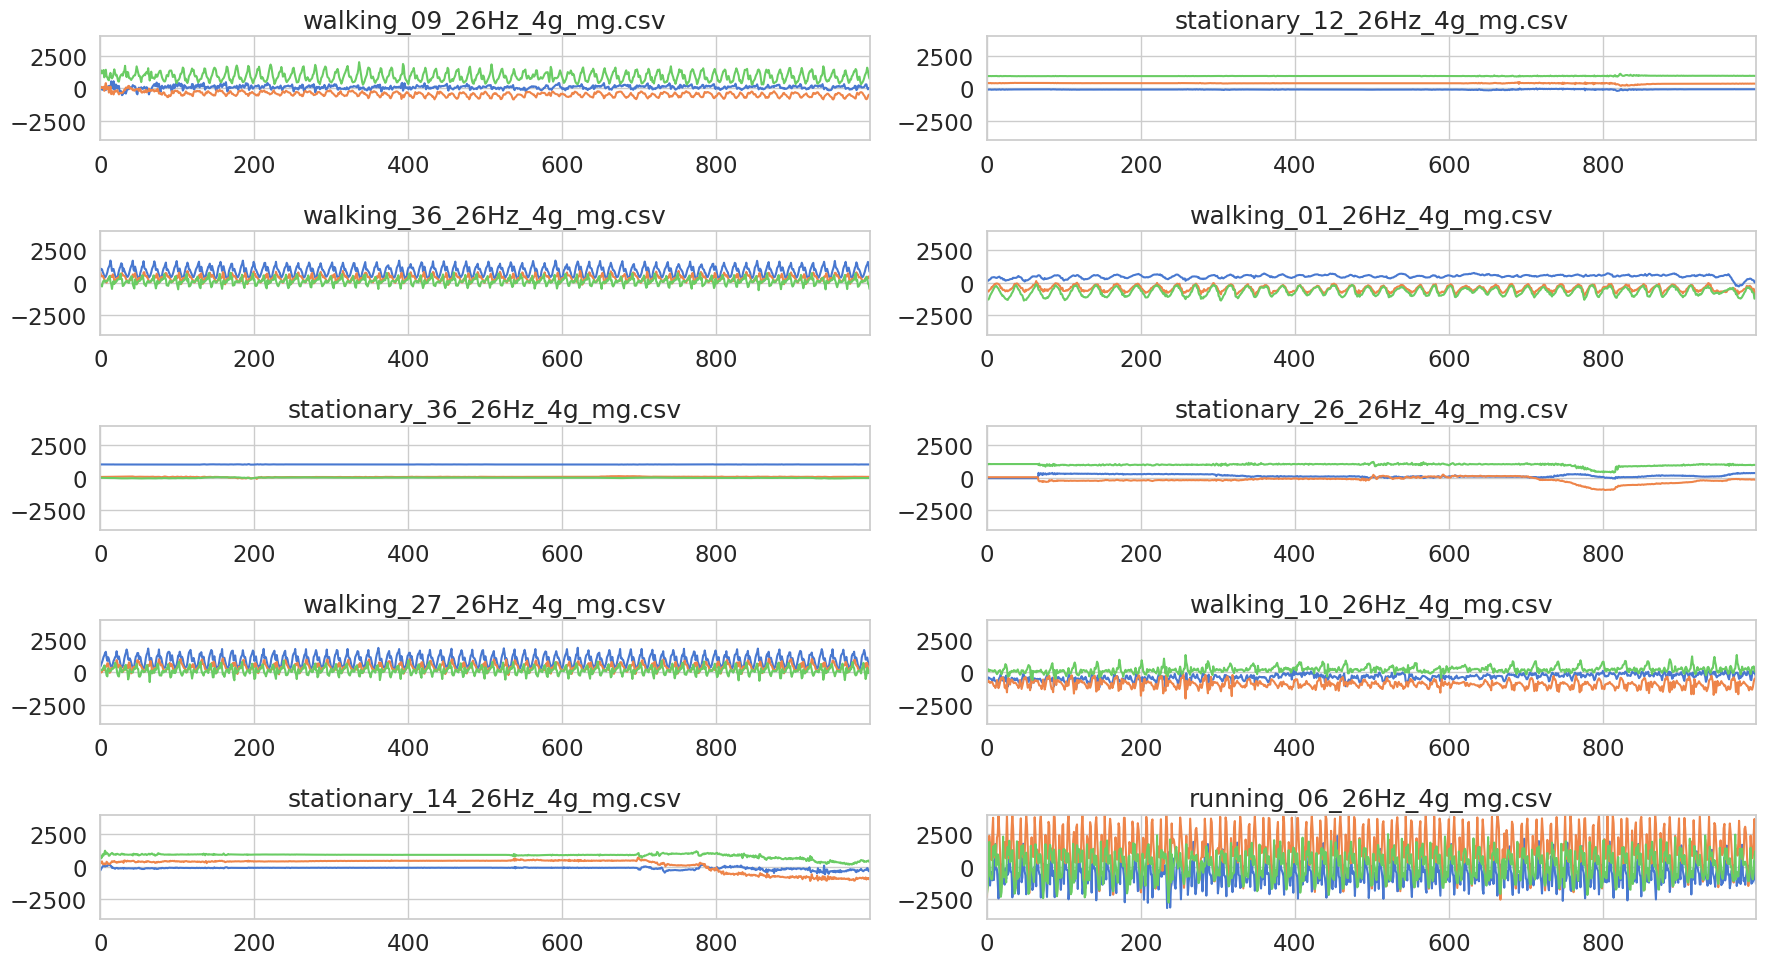

In [16]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

In [17]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(92, 75, 26, 3)
(6900, 26, 3)
(6900,)
['stationary', 'walking', 'running']


In [18]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (5175, 26, 3)
Testing samples: (1725, 26, 3)


In [21]:
## Conv1D based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(26, 3)),
  tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
model.summary()

Epoch 1/30
162/162 [==============================] - 5s 10ms/step - loss: 0.6962 - accuracy: 0.6798
Epoch 2/30
162/162 [==============================] - 2s 10ms/step - loss: 0.2690 - accuracy: 0.9071
Epoch 3/30
162/162 [==============================] - 1s 6ms/step - loss: 0.1294 - accuracy: 0.9610
Epoch 4/30
162/162 [==============================] - 1s 6ms/step - loss: 0.0981 - accuracy: 0.9710
Epoch 5/30
162/162 [==============================] - 1s 6ms/step - loss: 0.0976 - accuracy: 0.9699
Epoch 6/30
162/162 [==============================] - 1s 6ms/step - loss: 0.0834 - accuracy: 0.9720
Epoch 7/30
162/162 [==============================] - 1s 5ms/step - loss: 0.0788 - accuracy: 0.9753
Epoch 8/30
162/162 [==============================] - 1s 5ms/step - loss: 0.0739 - accuracy: 0.9749
Epoch 9/30
162/162 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.9782
Epoch 10/30
162/162 [==============================] - 1s 6ms/step - loss: 0.0644 - accuracy: 0.98

54/54 [==============================] - 0s 2ms/step


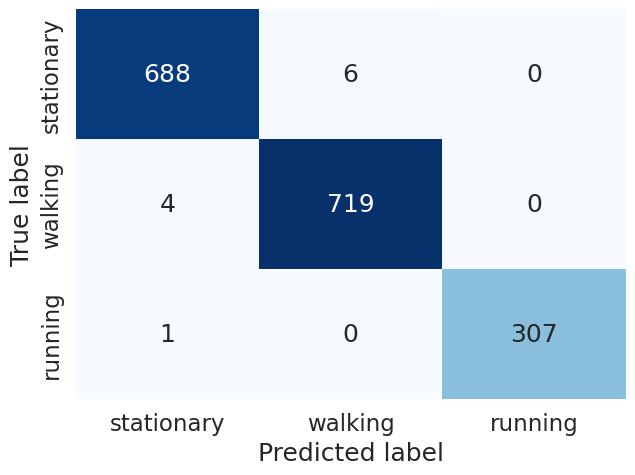

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
# Save the model into an HDF5 file ‘model.h5’
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
